# Préparation de l'espace de travail

## Importations

In [2]:
import geopandas as gpd
import pandas as pd
import contextily as ctx
import matplotlib.pyplot as plt
from cartiflette import carti_download
import plotly.express as px

## Lecture des feuilles Excel

In [3]:
# Lecture des différentes feuilles du Excel medecins
df_medecinsEffectif = pd.read_excel("medecins.xlsx", sheet_name='Effectif')
df_medecinsAge = pd.read_excel("medecins.xlsx", sheet_name=2)
df_medecinsDensite = pd.read_excel("medecins.xlsx", sheet_name=3)
df_medecinsEffectifsParSpe = pd.read_excel("medecins.xlsx", sheet_name=4)
df_medecinsEffectifsParLieu = pd.read_excel("medecins.xlsx", sheet_name=5)
df_medecinsNombreActivites = pd.read_excel("medecins.xlsx", sheet_name=6)

## Données Géospatiales

(np.float64(-5.876307480152819),
 np.float64(10.295160325375349),
 np.float64(40.84582809366395),
 np.float64(51.57675902873196))

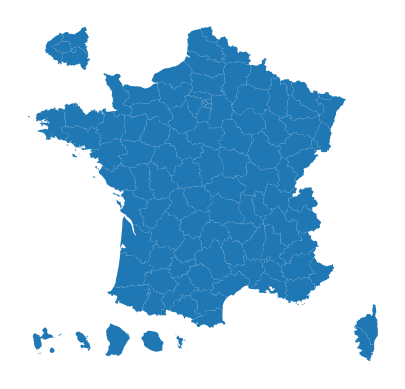

In [4]:
# Téléchargement des informations géospatiales des départements français (DROM compris)

departements = carti_download(
    values = ["France"],
    crs = 4326,
    borders = "DEPARTEMENT",
    vectorfile_format="geojson",
    simplification=50,
    filter_by="FRANCE_ENTIERE_DROM_RAPPROCHES",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022
)

# On modifie le code des départements : on rajoute un 0 à ceux qui ont un code à deux chiffres
departements['INSEE_DEP'] = departements['INSEE_DEP'].str.zfill(3)

# Test d'affichage de la carte
departements.plot().axis('off')

# Densité de médecins par département et par année

## Uniquement les spécialités dites de 'Médecine générale'

### Nouvelle base et jointure pour obtenir les données géospatiales 

In [192]:
# On garde uniquement les lignes pour lesquelles specialites_agregees = '1-Médecine générale', et telles que les départements sont différents
df = df_medecinsDensite[
    (df_medecinsDensite['specialites_agregees']=='1-Médecine générale') &
    (df_medecinsDensite['departement']!='000-Ensemble') &
    (df_medecinsDensite['sexe']=='0-Ensemble') & 
    (df_medecinsDensite['tranche_age']=='00-Ensemble') &
    (df_medecinsDensite['exercice']=='0-Ensemble') &
    (df_medecinsDensite['specialites']=='00-Ensemble')]

# On ajoute un code de département pour faire la jointure, en ne gardant que les 3 premiers caractères de la variable (qui correspondent au code du département)
df['INSEE_DEP'] = df['departement'].str[:3].astype(str)
print(df['INSEE_DEP'].unique())

# Jointure de la base de données à la base des départements
df = departements.merge(df, on='INSEE_DEP', how='left')

['075' '077' '078' '091' '092' '093' '094' '095' '018' '028' '036' '037'
 '041' '045' '021' '025' '039' '058' '070' '071' '089' '090' '014' '027'
 '050' '061' '076' '002' '059' '060' '062' '080' '008' '010' '051' '052'
 '054' '055' '057' '067' '068' '088' '044' '049' '053' '072' '085' '022'
 '029' '035' '056' '016' '017' '019' '023' '024' '033' '040' '047' '064'
 '079' '086' '087' '009' '011' '012' '030' '031' '032' '034' '046' '048'
 '065' '066' '081' '082' '001' '003' '007' '015' '026' '038' '042' '043'
 '063' '069' '073' '074' '004' '005' '006' '013' '083' '084' '02A' '02B'
 '971' '972' '973' '974' '976' '999']


/tmp/ipykernel_5367/818999975.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Tracé pour l'année 2012

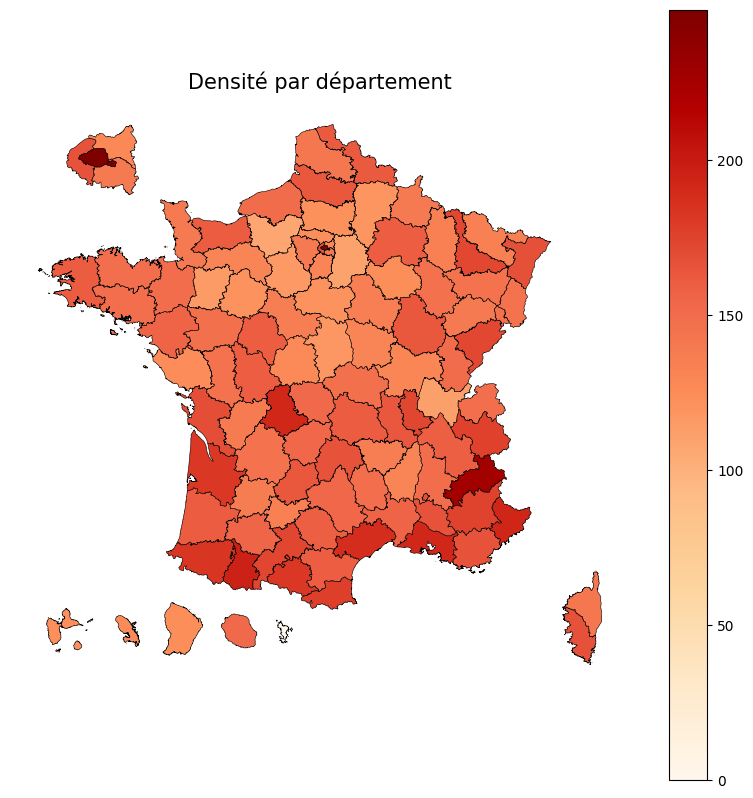

In [193]:
# Tracé pour l'année 2012
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
df.plot(
    column='densite_2012', 
    cmap='OrRd',      
    linewidth=0.4,
    edgecolor='black',
    legend=True,       
    ax=ax
)

# On supprime les axes
ax.axis('off')  
ax.set_title("Densité par département", fontsize=15)
plt.show()

### Carte interactive pour avoir toutes les années

In [194]:
# Transformation en tableau long
df_long = df.melt(
    id_vars=['INSEE_DEP', 'geometry'], 
    value_vars=[col for col in df.columns if col.startswith('densite_')],
    var_name='annee', 
    value_name='densite'
)

In [ ]:
# Plotly Express choropleth avec slider pour l'année
fig = px.choropleth(
    df_long,
    geojson=df_long.geometry.__geo_interface__,  # GeoJSON des départements
    locations=df_long.index,                     # chaque ligne correspond à un département
    color='densite',
    hover_name='INSEE_DEP',
    animation_frame='annee',                     # le curseur correspond à l'année
    color_continuous_scale='OrRd'
)

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(title_text="Densité par département selon l'année")
fig.show()

In [ ]:
import plotly.express as px
import json

# Convertir le GeoDataFrame en GeoJSON
#geojson = json.loads(departements.to_json())

# df_stats contient : INSEE_DEP, densite, annee
#fig = px.choropleth(
#    df_long,
#    geojson=geojson,
#    locations='INSEE_DEP',
#    color='densite',
#    animation_frame='annee',    # le slider
#    featureidkey='properties.INSEE_DEP', 
#    color_continuous_scale='OrRd'
#)

#fig.update_geos(fitbounds="locations", visible=False)
#fig.show()

## Toutes spécialités confondues

### Nouvelle base et jointure pour obtenir les données géospatiales 

In [ ]:
# On garde toutes les lignes d'ensemble des médecins, mais telles que les départements sont différents
df = df_medecinsDensite[
    (df_medecinsDensite['specialites_agregees']=='00-Ensemble') &
    (df_medecinsDensite['departement']!='000-Ensemble') &
    (df_medecinsDensite['sexe']=='0-Ensemble') & 
    (df_medecinsDensite['tranche_age']=='00-Ensemble') &
    (df_medecinsDensite['exercice']=='0-Ensemble') &
    (df_medecinsDensite['specialites']=='00-Ensemble')]

# On ajoute un code de département pour faire la jointure, en ne gardant que les 3 premiers caractères de la variable (qui correspondent au code du département)
df['INSEE_DEP'] = df['departement'].str[:3].astype(str)
print(df['INSEE_DEP'].unique())

# Jointure de la base de données à la base des départements
df = departements.merge(df, on='INSEE_DEP', how='left')

['075' '077' '078' '091' '092' '093' '094' '095' '018' '028' '036' '037'
 '041' '045' '021' '025' '039' '058' '070' '071' '089' '090' '014' '027'
 '050' '061' '076' '002' '059' '060' '062' '080' '008' '010' '051' '052'
 '054' '055' '057' '067' '068' '088' '044' '049' '053' '072' '085' '022'
 '029' '035' '056' '016' '017' '019' '023' '024' '033' '040' '047' '064'
 '079' '086' '087' '009' '011' '012' '030' '031' '032' '034' '046' '048'
 '065' '066' '081' '082' '001' '003' '007' '015' '026' '038' '042' '043'
 '063' '069' '073' '074' '004' '005' '006' '013' '083' '084' '02A' '02B'
 '971' '972' '973' '974' '976' '999']


/tmp/ipykernel_64444/2259886179.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['INSEE_DEP'] = df['departement'].str[:3].astype(str)


### Tracés

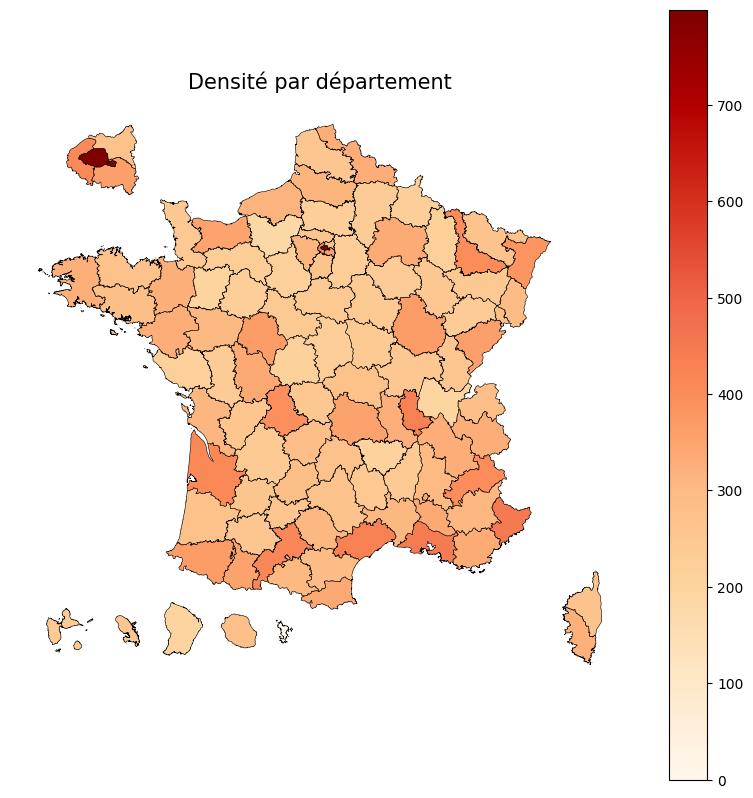

In [6]:
# Tracé pour l'année 2012
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
df.plot(
    column='densite_2012', 
    cmap='OrRd',      
    linewidth=0.4,
    edgecolor='black',
    legend=True, 
    ax=ax
)

# On supprime les axes
ax.axis('off')  
ax.set_title("Densité par département", fontsize=15)
plt.title='Densité par départements, tous médecins confondus (2012)'
plt.show()